# Importing Libraries

In [1]:
from tqdm import tqdm
import torch
import numpy as np
import seaborn as sns
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch import inference_mode
from sklearn.metrics import accuracy_score
from torch.nn import Linear, BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from torchvision.models.regnet import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

import sys
sys.path.append("../")
from utils import CustomDataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

# RegNet Model

## Loading Pre-trained model and weights

In [3]:
weights = RegNet_Y_3_2GF_Weights.IMAGENET1K_V2
model = regnet_y_3_2gf(weights=weights)

## Loading and Preparing Data

In [4]:
train_dataset = CustomDataset("../Data/Processed/train_set.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'])
test_dataset = CustomDataset("../Data/Processed/test_set.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'])
val_dataset = CustomDataset("../Data/Processed/val_set.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'])

train_loader = DataLoader(train_dataset, 16, shuffle=True)
test_loader = DataLoader(test_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16, shuffle=True)

In [5]:
train_dataset.__len__(), test_dataset.__len__(), val_dataset.__len__()

(650, 186, 93)

In [6]:
num_classes = 28
in_features = model.fc.in_features
model.fc = Linear(in_features, num_classes)

## Loss function and optimizer

In [7]:
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [8]:
try:
    print(10/0)
except:
    pass
print(1)

1


## Training Loop

In [9]:
def TrainLoop(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader=None,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    return_best_model:bool=True,
    device:str='cpu'
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    total_train_loss = []
    total_val_loss = []
    total_test_loss = []
    best_model_weights = model.state_dict()

    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("\nEpoch {}\n----------".format(epoch))
        train_loss = 0
        for i, (batch, label) in enumerate(train_dataloader):
            batch, label = batch.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, label.float())
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
        total_train_loss.append(train_loss/len(train_dataloader.dataset))

        model.eval()
        validation_loss = 0
        with inference_mode():
            val_true_labels = []
            train_true_labels = []
            val_pred_labels = []
            train_pred_labels = []
            for batch, label in val_dataloader:
                batch, label = batch.to(device), label.to(device)
                outputs = model(batch)
                loss = criterion(outputs, label.float())
                validation_loss += loss

                outputs = torch.round(torch.sigmoid(outputs))
                val_true_labels.extend(label.cpu().numpy())
                val_pred_labels.extend(outputs.cpu().numpy())

            for batch, label in train_dataloader:
                batch, label = batch.to(device), label.to(device)
                outputs = model(batch)

                outputs = torch.round(torch.sigmoid(outputs))
                train_true_labels.extend(label.cpu().numpy())
                train_pred_labels.extend(outputs.cpu().numpy())

            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
                best_model_weights = model.state_dict()
            else:
                epochs_without_improvement += 1

            val_true_labels = np.array(val_true_labels)
            train_true_labels = np.array(train_true_labels)
            val_pred_labels = np.array(val_pred_labels)
            train_pred_labels = np.array(train_pred_labels)

            train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Current Validation Loss = {validation_loss}")
            print(f"Best Validation Loss = {best_val_loss}")
            print(f"Epochs without Improvement = {epochs_without_improvement}")

            print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

        total_val_loss.append(validation_loss/len(val_dataloader.dataset))

        if test_dataloader is not None:
            test_loss = 0
            with inference_mode():
                for batch, label in test_dataloader:
                    batch, label = batch.to(device), label.to(device)
                    outputs = model(batch)
                    loss = criterion(outputs, label.float())
                    test_loss += loss

                print("\nTest Loss for epoch {} = {}\n".format(epoch, test_loss))
            total_test_loss.append(test_loss/len(test_dataloader.dataset))

        if epochs_without_improvement >= early_stopping_rounds:
            print("Early Stoppping Triggered")
            break

    if return_best_model == True:
        model.load_state_dict(best_model_weights)
    total_train_loss = [item.cpu().detach().numpy() for item in total_train_loss]
    total_val_loss = [item.cpu().detach().numpy() for item in total_val_loss]

    total_train_loss = np.array(total_train_loss)
    total_val_loss = np.array(total_val_loss)

    train_accuracies = np.array(train_accuracies)
    val_accuracies = np.array(val_accuracies)

    x_train = np.arange(len(total_train_loss))
    x_val = np.arange(len(total_val_loss))
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    try:
        total_test_loss = [item.cpu().detach().numpy() for item in total_test_loss]
        total_test_loss = np.array(total_test_loss)
        x_test = np.arange(len(total_test_loss))
        sns.lineplot(x=x_test, y=total_test_loss, label='Testing Loss')
    except:
        pass

    sns.lineplot(x=x_train, y=total_train_loss, label='Training Loss')
    sns.lineplot(x=x_val, y=total_val_loss, label='Validation Loss')
    plt.title("Loss over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(total_train_loss)))
    
    plt.subplot(1,2,2)
    sns.lineplot(x=x_train, y=train_accuracies, label='Training Accuracy')
    sns.lineplot(x=x_val, y=val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(total_train_loss)))

    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 0.6856558322906494
Loss for batch 1 = 0.20867082476615906
Loss for batch 2 = 0.27712875604629517
Loss for batch 3 = 0.241267591714859
Loss for batch 4 = 0.33360034227371216
Loss for batch 5 = 0.1790737360715866
Loss for batch 6 = 0.17703087627887726
Loss for batch 7 = 0.20865942537784576
Loss for batch 8 = 0.1642775535583496
Loss for batch 9 = 0.1230173334479332
Loss for batch 10 = 0.14983423054218292
Loss for batch 11 = 0.10956093668937683
Loss for batch 12 = 0.09882206469774246
Loss for batch 13 = 0.30712100863456726
Loss for batch 14 = 0.20490199327468872
Loss for batch 15 = 0.14298534393310547
Loss for batch 16 = 0.18535467982292175
Loss for batch 17 = 0.18214748799800873
Loss for batch 18 = 0.16766999661922455
Loss for batch 19 = 0.1372305154800415
Loss for batch 20 = 0.18892468512058258
Loss for batch 21 = 0.10054684430360794
Loss for batch 22 = 0.12527978420257568
Loss for batch 23 = 0.12984691560268402
Loss for batch 24 = 0.105818919837474

 10%|█         | 1/10 [01:47<16:11, 107.90s/it]

Current Validation Loss = 13.729776382446289
Best Validation Loss = 13.729776382446289
Epochs without Improvement = 0
Train Accuracy: 63.54%
Validation Accuracy: 55.91%

Epoch 1
----------
Loss for batch 0 = 0.18449287116527557
Loss for batch 1 = 0.11716261506080627
Loss for batch 2 = 0.17709681391716003
Loss for batch 3 = 0.09416212886571884
Loss for batch 4 = 0.12313976138830185
Loss for batch 5 = 0.06657745689153671
Loss for batch 6 = 0.11369393765926361
Loss for batch 7 = 0.11292010545730591
Loss for batch 8 = 0.07560165226459503
Loss for batch 9 = 0.12522906064987183
Loss for batch 10 = 0.20912034809589386
Loss for batch 11 = 0.1087438240647316
Loss for batch 12 = 0.1586894690990448
Loss for batch 13 = 0.15427808463573456
Loss for batch 14 = 0.10961998254060745
Loss for batch 15 = 0.12059618532657623
Loss for batch 16 = 0.07841098308563232
Loss for batch 17 = 0.11507702618837357
Loss for batch 18 = 0.13011914491653442
Loss for batch 19 = 0.12323077023029327
Loss for batch 20 = 0.1

 20%|██        | 2/10 [03:35<14:23, 107.98s/it]

Current Validation Loss = 1.090670108795166
Best Validation Loss = 1.090670108795166
Epochs without Improvement = 0
Train Accuracy: 63.08%
Validation Accuracy: 55.91%

Epoch 2
----------
Loss for batch 0 = 0.08545324206352234
Loss for batch 1 = 0.10407280176877975
Loss for batch 2 = 0.12203200161457062
Loss for batch 3 = 0.12177596241235733
Loss for batch 4 = 0.07782049477100372
Loss for batch 5 = 0.11602324992418289
Loss for batch 6 = 0.14707978069782257
Loss for batch 7 = 0.07846732437610626
Loss for batch 8 = 0.05965409427881241
Loss for batch 9 = 0.0837550237774849
Loss for batch 10 = 0.1180826723575592
Loss for batch 11 = 0.14224891364574432
Loss for batch 12 = 0.09083159267902374
Loss for batch 13 = 0.1580059975385666
Loss for batch 14 = 0.1488553285598755
Loss for batch 15 = 0.11521506309509277
Loss for batch 16 = 0.13767223060131073
Loss for batch 17 = 0.13060390949249268
Loss for batch 18 = 0.07613204419612885
Loss for batch 19 = 0.11322572082281113
Loss for batch 20 = 0.13236

 30%|███       | 3/10 [05:21<12:28, 106.90s/it]

Current Validation Loss = 0.7871531248092651
Best Validation Loss = 0.7871531248092651
Epochs without Improvement = 0
Train Accuracy: 62.31%
Validation Accuracy: 54.84%

Epoch 3
----------
Loss for batch 0 = 0.1101786270737648
Loss for batch 1 = 0.08127381652593613
Loss for batch 2 = 0.11129380762577057
Loss for batch 3 = 0.11306464672088623
Loss for batch 4 = 0.09798791259527206
Loss for batch 5 = 0.08872037380933762
Loss for batch 6 = 0.17304788529872894
Loss for batch 7 = 0.04786035045981407
Loss for batch 8 = 0.09952462464570999
Loss for batch 9 = 0.10105931013822556
Loss for batch 10 = 0.07244038581848145
Loss for batch 11 = 0.139828160405159
Loss for batch 12 = 0.07590710371732712
Loss for batch 13 = 0.11163729429244995
Loss for batch 14 = 0.08771475404500961
Loss for batch 15 = 0.1568380445241928
Loss for batch 16 = 0.14747516810894012
Loss for batch 17 = 0.11504290997982025
Loss for batch 18 = 0.11962345242500305
Loss for batch 19 = 0.14179030060768127
Loss for batch 20 = 0.106

 40%|████      | 4/10 [07:06<10:36, 106.12s/it]

Current Validation Loss = 0.7655547857284546
Best Validation Loss = 0.7655547857284546
Epochs without Improvement = 0
Train Accuracy: 56.31%
Validation Accuracy: 43.01%

Epoch 4
----------
Loss for batch 0 = 0.07851926237344742
Loss for batch 1 = 0.10436399281024933
Loss for batch 2 = 0.12084285169839859
Loss for batch 3 = 0.09278424084186554
Loss for batch 4 = 0.09508350491523743
Loss for batch 5 = 0.06653983145952225
Loss for batch 6 = 0.09603379666805267
Loss for batch 7 = 0.1314566433429718
Loss for batch 8 = 0.04289336875081062
Loss for batch 9 = 0.12794463336467743
Loss for batch 10 = 0.10212281346321106
Loss for batch 11 = 0.07815735787153244
Loss for batch 12 = 0.09847046434879303
Loss for batch 13 = 0.14144620299339294
Loss for batch 14 = 0.14475534856319427
Loss for batch 15 = 0.15171439945697784
Loss for batch 16 = 0.15043163299560547
Loss for batch 17 = 0.16579394042491913
Loss for batch 18 = 0.09831986576318741
Loss for batch 19 = 0.1429874151945114
Loss for batch 20 = 0.1

 50%|█████     | 5/10 [08:52<08:51, 106.20s/it]

Current Validation Loss = 0.8149213790893555
Best Validation Loss = 0.7655547857284546
Epochs without Improvement = 1
Train Accuracy: 12.92%
Validation Accuracy: 10.75%

Epoch 5
----------
Loss for batch 0 = 0.10734286904335022
Loss for batch 1 = 0.10659816116094589
Loss for batch 2 = 0.10947759449481964
Loss for batch 3 = 0.15724584460258484
Loss for batch 4 = 0.11780960857868195
Loss for batch 5 = 0.07050270587205887
Loss for batch 6 = 0.11635121703147888
Loss for batch 7 = 0.11715461313724518
Loss for batch 8 = 0.07913728803396225
Loss for batch 9 = 0.11861542612314224
Loss for batch 10 = 0.08842287957668304
Loss for batch 11 = 0.0987369641661644
Loss for batch 12 = 0.13456541299819946
Loss for batch 13 = 0.09759506583213806
Loss for batch 14 = 0.14431257545948029
Loss for batch 15 = 0.05563202500343323
Loss for batch 16 = 0.14442968368530273
Loss for batch 17 = 0.1206122487783432
Loss for batch 18 = 0.13961394131183624
Loss for batch 19 = 0.15334603190422058
Loss for batch 20 = 0.1

 60%|██████    | 6/10 [10:38<07:04, 106.07s/it]

Current Validation Loss = 0.7641608715057373
Best Validation Loss = 0.7641608715057373
Epochs without Improvement = 0
Train Accuracy: 52.46%
Validation Accuracy: 47.31%

Epoch 6
----------
Loss for batch 0 = 0.15638437867164612
Loss for batch 1 = 0.1488717645406723
Loss for batch 2 = 0.13392430543899536
Loss for batch 3 = 0.09148888289928436
Loss for batch 4 = 0.07711215317249298
Loss for batch 5 = 0.06203656271100044
Loss for batch 6 = 0.08949130028486252
Loss for batch 7 = 0.03619984909892082
Loss for batch 8 = 0.10553304851055145
Loss for batch 9 = 0.03147542476654053
Loss for batch 10 = 0.04280687868595123
Loss for batch 11 = 0.30500099062919617
Loss for batch 12 = 0.17189554870128632
Loss for batch 13 = 0.19696642458438873
Loss for batch 14 = 0.12320658564567566
Loss for batch 15 = 0.12428539991378784
Loss for batch 16 = 0.21142616868019104
Loss for batch 17 = 0.11002454161643982
Loss for batch 18 = 0.15287256240844727
Loss for batch 19 = 0.1005040779709816
Loss for batch 20 = 0.1

 70%|███████   | 7/10 [12:25<05:18, 106.19s/it]

Current Validation Loss = 1.274890661239624
Best Validation Loss = 0.7641608715057373
Epochs without Improvement = 1
Train Accuracy: 26.92%
Validation Accuracy: 32.26%

Epoch 7
----------
Loss for batch 0 = 0.0785309225320816
Loss for batch 1 = 0.10047240555286407
Loss for batch 2 = 0.12348243594169617
Loss for batch 3 = 0.11627227813005447
Loss for batch 4 = 0.1152975931763649
Loss for batch 5 = 0.1221831887960434
Loss for batch 6 = 0.1298643946647644
Loss for batch 7 = 0.17088337242603302
Loss for batch 8 = 0.11781276017427444
Loss for batch 9 = 0.10236410796642303
Loss for batch 10 = 0.12148629128932953
Loss for batch 11 = 0.09739109128713608
Loss for batch 12 = 0.14117787778377533
Loss for batch 13 = 0.09369612485170364
Loss for batch 14 = 0.13654208183288574
Loss for batch 15 = 0.1098995953798294
Loss for batch 16 = 0.10538777709007263
Loss for batch 17 = 0.10840220749378204
Loss for batch 18 = 0.08558730036020279
Loss for batch 19 = 0.06979043781757355
Loss for batch 20 = 0.06665

 80%|████████  | 8/10 [14:12<03:33, 106.55s/it]

Current Validation Loss = 0.9943233728408813
Best Validation Loss = 0.7641608715057373
Epochs without Improvement = 2
Train Accuracy: 62.15%
Validation Accuracy: 54.84%

Epoch 8
----------
Loss for batch 0 = 0.09070254862308502
Loss for batch 1 = 0.08253034204244614
Loss for batch 2 = 0.1140267476439476
Loss for batch 3 = 0.09674482047557831
Loss for batch 4 = 0.15531620383262634
Loss for batch 5 = 0.09067676216363907
Loss for batch 6 = 0.08412672579288483
Loss for batch 7 = 0.08328451961278915
Loss for batch 8 = 0.1664838194847107
Loss for batch 9 = 0.10731075704097748
Loss for batch 10 = 0.11205913871526718
Loss for batch 11 = 0.10356961190700531
Loss for batch 12 = 0.10535434633493423
Loss for batch 13 = 0.11474509537220001
Loss for batch 14 = 0.13012878596782684
Loss for batch 15 = 0.14233751595020294
Loss for batch 16 = 0.12144312262535095
Loss for batch 17 = 0.11978507786989212
Loss for batch 18 = 0.08988679200410843
Loss for batch 19 = 0.12423074245452881
Loss for batch 20 = 0.0

 90%|█████████ | 9/10 [15:59<01:46, 106.71s/it]

Current Validation Loss = 0.8182677626609802
Best Validation Loss = 0.7641608715057373
Epochs without Improvement = 3
Train Accuracy: 50.77%
Validation Accuracy: 50.54%

Epoch 9
----------
Loss for batch 0 = 0.09207461029291153
Loss for batch 1 = 0.14101770520210266
Loss for batch 2 = 0.17543430626392365
Loss for batch 3 = 0.12220493704080582
Loss for batch 4 = 0.09453185647726059
Loss for batch 5 = 0.07728662341833115
Loss for batch 6 = 0.13043175637722015
Loss for batch 7 = 0.08228057622909546
Loss for batch 8 = 0.07329236716032028
Loss for batch 9 = 0.11688514053821564
Loss for batch 10 = 0.08320782333612442
Loss for batch 11 = 0.07779045403003693
Loss for batch 12 = 0.08624763786792755
Loss for batch 13 = 0.12439273297786713
Loss for batch 14 = 0.09078939259052277
Loss for batch 15 = 0.08936737477779388
Loss for batch 16 = 0.1227002963423729
Loss for batch 17 = 0.1475507766008377
Loss for batch 18 = 0.11593914031982422
Loss for batch 19 = 0.0723741203546524
Loss for batch 20 = 0.09

 90%|█████████ | 9/10 [17:46<01:58, 118.51s/it]


Current Validation Loss = 0.9721548557281494
Best Validation Loss = 0.7641608715057373
Epochs without Improvement = 4
Train Accuracy: 62.92%
Validation Accuracy: 58.06%
Early Stoppping Triggered


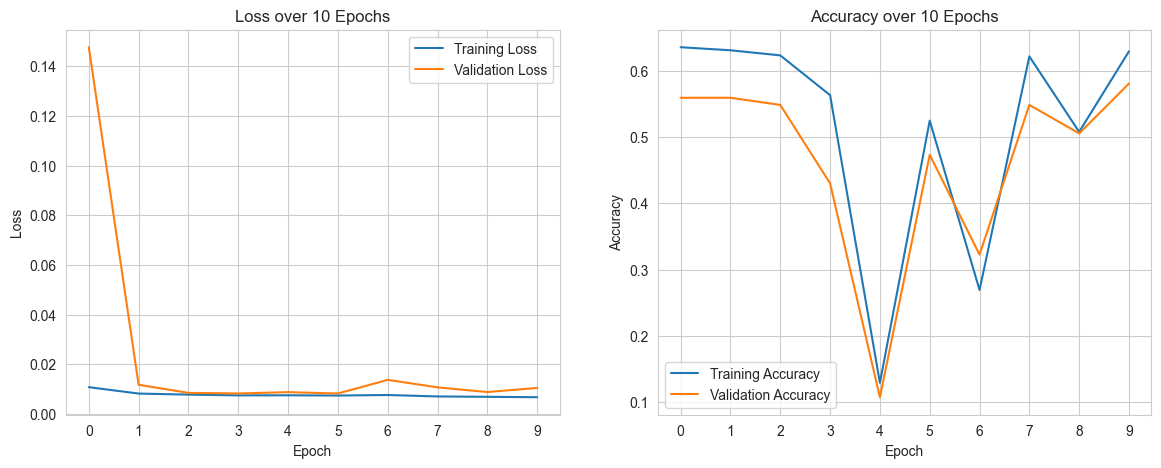

In [10]:
TrainLoop(model, optimizer, criterion, train_loader, val_loader, num_epochs=10, early_stopping_rounds=4, device='cuda')

In [11]:
torch.cuda.empty_cache()

In [12]:
# from sklearn.metrics import accuracy_score
model.to('cpu')
true_labels = []
pred_labels = []
model.eval()
with torch.inference_mode():
    for batch, labels in test_loader:
        batch.to('cpu'), labels.to('cpu')
        outputs = model(batch)
        preds = torch.round(torch.sigmoid(outputs))
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 53.23%


In [27]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cf = multilabel_confusion_matrix(true_labels, pred_labels)
cf

array([[[186,   0],
        [  0,   0]],

       [[186,   0],
        [  0,   0]],

       [[172,   0],
        [ 14,   0]],

       [[ 30,  58],
        [  9,  89]],

       [[186,   0],
        [  0,   0]],

       [[186,   0],
        [  0,   0]],

       [[176,   0],
        [ 10,   0]],

       [[185,   0],
        [  1,   0]],

       [[185,   0],
        [  1,   0]],

       [[183,   0],
        [  3,   0]],

       [[182,   0],
        [  4,   0]],

       [[182,   0],
        [  4,   0]],

       [[182,   0],
        [  4,   0]],

       [[184,   0],
        [  2,   0]],

       [[186,   0],
        [  0,   0]],

       [[185,   0],
        [  1,   0]],

       [[184,   0],
        [  2,   0]],

       [[185,   0],
        [  1,   0]],

       [[176,   0],
        [ 10,   0]],

       [[  0,  24],
        [  2, 160]],

       [[182,   0],
        [  4,   0]],

       [[186,   0],
        [  0,   0]],

       [[183,   0],
        [  3,   0]],

       [[182,   0],
        [  4, 

In [32]:
q = np.array([[1,1],[1,1]])
w = np.array([[1,0],[1,0]])
accuracy_score(q,w)

0.0

# Efficient net

In [ ]:
from torch import save, load
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torch.nn import Linear, BCEWithLogitsLoss, ReLU, Dropout, Sequential
from torchvision.models.efficientnet import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models.regnet import regnet_y_3_2gf, RegNet_Y_3_2GF_Weights

In [ ]:
import sys
sys.path.append("../")
from utils import CustomDataset, TrainLoop, transform

import warnings
warnings.filterwarnings("ignore")

In [ ]:
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)
data = CustomDataset("../Data/processed_metadata.csv", "../Data/images", "filename", ['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila', 'E.Coli', 'Fungal', 'H1N1', 'Herpes ', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Unknown', 'Varicella', 'Viral', 'todo'])

train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    data, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, 16, shuffle=True)
test_loader = DataLoader(test_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16, shuffle=True)

num_classes = 28

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
model.classifier = Sequential(
    Dropout(p=0.2),
    ReLU(),
    Linear(in_features=1280, out_features=28)
)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 0.7037026882171631
Loss for batch 1 = 0.36558178067207336
Loss for batch 2 = 0.2800663113594055
Loss for batch 3 = 0.2173284888267517
Loss for batch 4 = 0.15282079577445984
Loss for batch 5 = 0.24037282168865204
Loss for batch 6 = 0.22420458495616913
Loss for batch 7 = 0.16499380767345428
Loss for batch 8 = 0.1697271317243576
Loss for batch 9 = 0.17842084169387817
Loss for batch 10 = 0.16511645913124084
Loss for batch 11 = 0.15919403731822968
Loss for batch 12 = 0.15969066321849823
Loss for batch 13 = 0.12092731893062592
Loss for batch 14 = 0.10495949536561966
Loss for batch 15 = 0.13125254213809967
Loss for batch 16 = 0.13061150908470154
Loss for batch 17 = 0.185589998960495
Loss for batch 18 = 0.1805395483970642
Loss for batch 19 = 0.1688186526298523
Loss for batch 20 = 0.13813745975494385
Loss for batch 21 = 0.14945824444293976
Loss for batch 22 = 0.16325831413269043
Loss for batch 23 = 0.12249930202960968
Loss for batch 24 = 0.0849449783563613

 20%|██        | 1/5 [02:03<08:13, 123.43s/it]


Test Loss for epoch 0 = 1.7818275690078735


Epoch 1
----------
Loss for batch 0 = 0.16636593639850616
Loss for batch 1 = 0.13774868845939636
Loss for batch 2 = 0.11148324608802795
Loss for batch 3 = 0.14163905382156372
Loss for batch 4 = 0.1161298155784607
Loss for batch 5 = 0.11702953279018402
Loss for batch 6 = 0.1212419867515564
Loss for batch 7 = 0.09649877995252609
Loss for batch 8 = 0.11689702421426773
Loss for batch 9 = 0.11374913156032562
Loss for batch 10 = 0.10006581246852875
Loss for batch 11 = 0.13535559177398682
Loss for batch 12 = 0.10814709961414337
Loss for batch 13 = 0.13446438312530518
Loss for batch 14 = 0.15999266505241394
Loss for batch 15 = 0.1293289214372635
Loss for batch 16 = 0.11842070519924164
Loss for batch 17 = 0.11341556161642075
Loss for batch 18 = 0.19836591184139252
Loss for batch 19 = 0.0815669447183609
Loss for batch 20 = 0.12642362713813782
Loss for batch 21 = 0.11550681293010712
Loss for batch 22 = 0.09859500080347061
Loss for batch 23 = 0.0906359

 40%|████      | 2/5 [03:50<05:41, 113.78s/it]


Test Loss for epoch 1 = 1.7610769271850586


Epoch 2
----------
Loss for batch 0 = 0.11204865574836731
Loss for batch 1 = 0.09237723052501678
Loss for batch 2 = 0.1448802500963211
Loss for batch 3 = 0.06950585544109344
Loss for batch 4 = 0.16122221946716309
Loss for batch 5 = 0.1527482122182846
Loss for batch 6 = 0.1144220232963562
Loss for batch 7 = 0.13000386953353882
Loss for batch 8 = 0.1115892305970192
Loss for batch 9 = 0.18783682584762573
Loss for batch 10 = 0.13280494511127472
Loss for batch 11 = 0.11394550651311874
Loss for batch 12 = 0.11395848542451859
Loss for batch 13 = 0.07698357105255127
Loss for batch 14 = 0.1332383006811142
Loss for batch 15 = 0.16293005645275116
Loss for batch 16 = 0.16761444509029388
Loss for batch 17 = 0.1170307993888855
Loss for batch 18 = 0.08612453192472458
Loss for batch 19 = 0.11011829227209091
Loss for batch 20 = 0.0920179933309555
Loss for batch 21 = 0.10846245288848877
Loss for batch 22 = 0.12374541908502579
Loss for batch 23 = 0.1474645435

 60%|██████    | 3/5 [05:32<03:36, 108.36s/it]


Test Loss for epoch 2 = 1.443204402923584


Epoch 3
----------
Loss for batch 0 = 0.14512503147125244
Loss for batch 1 = 0.061945319175720215
Loss for batch 2 = 0.1061493381857872
Loss for batch 3 = 0.17136329412460327
Loss for batch 4 = 0.09004596620798111
Loss for batch 5 = 0.10327888280153275
Loss for batch 6 = 0.12457635253667831
Loss for batch 7 = 0.10667047649621964
Loss for batch 8 = 0.14734125137329102
Loss for batch 9 = 0.09417866170406342
Loss for batch 10 = 0.09638218581676483
Loss for batch 11 = 0.10604648292064667
Loss for batch 12 = 0.0792723223567009
Loss for batch 13 = 0.07938513904809952
Loss for batch 14 = 0.09839259088039398
Loss for batch 15 = 0.13743150234222412
Loss for batch 16 = 0.11013118177652359
Loss for batch 17 = 0.11996446549892426
Loss for batch 18 = 0.1615402102470398
Loss for batch 19 = 0.09707121551036835
Loss for batch 20 = 0.08992139995098114
Loss for batch 21 = 0.14254483580589294
Loss for batch 22 = 0.11967737227678299
Loss for batch 23 = 0.125244

 80%|████████  | 4/5 [07:38<01:55, 115.32s/it]


Test Loss for epoch 3 = 1.7987107038497925


Epoch 4
----------
Loss for batch 0 = 0.08390549570322037
Loss for batch 1 = 0.14578063786029816
Loss for batch 2 = 0.11086152493953705
Loss for batch 3 = 0.09338054060935974
Loss for batch 4 = 0.0993499606847763
Loss for batch 5 = 0.08596663177013397
Loss for batch 6 = 0.07371514290571213
Loss for batch 7 = 0.15110354125499725
Loss for batch 8 = 0.1385015845298767
Loss for batch 9 = 0.18445131182670593
Loss for batch 10 = 0.10539869964122772
Loss for batch 11 = 0.1545860767364502
Loss for batch 12 = 0.13848444819450378
Loss for batch 13 = 0.10429458320140839
Loss for batch 14 = 0.15642006695270538
Loss for batch 15 = 0.12039253860712051
Loss for batch 16 = 0.1346454620361328
Loss for batch 17 = 0.16016340255737305
Loss for batch 18 = 0.11103694140911102
Loss for batch 19 = 0.0819741040468216
Loss for batch 20 = 0.1044861450791359
Loss for batch 21 = 0.08765452355146408
Loss for batch 22 = 0.16926456987857819
Loss for batch 23 = 0.132559537

100%|██████████| 5/5 [09:43<00:00, 116.70s/it]


Test Loss for epoch 4 = 1.6338430643081665



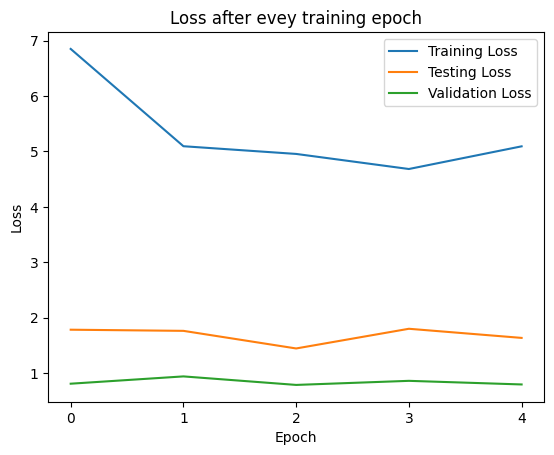

In [ ]:
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.005)

TrainLoop(model, optimizer, criterion, train_loader, test_loader, val_loader, device='cuda', num_epochs=5, early_stopping_rounds=3)

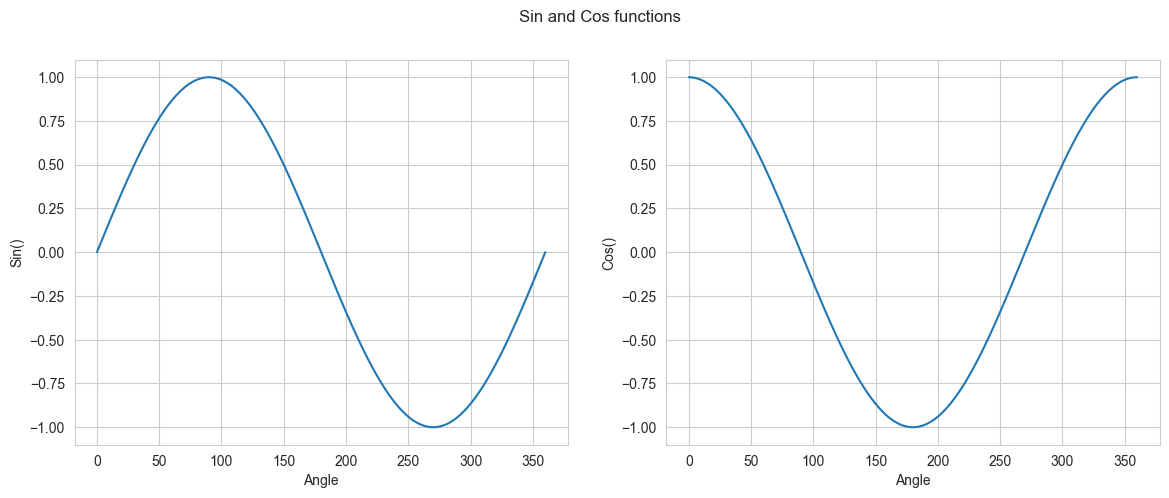

In [41]:
a = np.arange(0,361)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
b = np.sin(np.deg2rad(a))
plt.plot(a,b)
plt.xlabel("Angle")
plt.ylabel("Sin()")
# plt.show()

plt.subplot(1,2,2)
c = np.cos(np.deg2rad(a))
plt.plot(a,c)
plt.xlabel("Angle")
plt.ylabel("Cos()")

plt.suptitle("Sin and Cos functions")
plt.show()